In [2]:
import numpy as np
from numpy import linalg
from scipy import linalg as splinalg
import matplotlib.pyplot as plt
from scipy import sparse as sp
import scipy.sparse.linalg
from functools import reduce
import itertools
from scipy import linalg
from scipy.linalg import expm

In [3]:
print(np.__version__)
print(np.__path__)

1.24.3
['D:\\AnacondaFinal\\anacondaInstall\\envs\\WalshPulseSeq\\lib\\site-packages\\numpy']


# Using Numpy and Scipy

In [4]:
# Pauli Matrices
sigmaZ = sp.csc_matrix([[1, 0], [0, -1]])
sigmaX = sp.csc_matrix([[0, 1], [1, 0]])
sigmaY = sp.csc_matrix([[0, -1j], [1j, 0]])
sigmaI = sp.csc_matrix([[1, 0], [0, 1]])
sigmaH = sp.csc_matrix([[1, 1], [1, -1]])

Z = np.array([[1, 0], [0, -1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
I = np.array([[1, 0], [0, 1]])

H = np.array([[1, 1], [1, -1]])

params = {
'N' : 1,
'tau_list':[0.05, 0.1, 0.5, 1],
'tau': 0.1,
'n': 2,
'alpha': 1,
'T': 10,
    'R': [],
    'r': [],
    'alpha': 1,
'opH': [X, Y], # Need to change this specific to Model
'pulses': [I, Z] # Need to change this specific to Model
}

In [5]:
def normalizeWF(psi,**kwargs):
    shape, dtype = psi.shape, psi.dtype
    NWF = psi
    if np.array_equal(psi, np.zeros(shape, dtype = dtype)) == True:
        NWF = psi
    elif np.vdot(psi, psi) == 0:
        NWF = psi
    else:
        NWF = psi/(np.sqrt(np.vdot(psi, psi)))
    return NWF

def initialVals(params, **kwargs):
    n = params['n']
    N = params['N']
    alpha = params['alpha']
    op = params['opH']
    pulses = params['pulses']
    r = list(np.random.randint(low = 1,high=30,size=N))
    R = [np.power(1/x, alpha) for x in r]
    # r = np.random.random_sample(size = 2**N)
    psi0 = np.random.randn(2**N)
    psi_nm = normalizeWF(psi0)
    return n, N, r, op, pulses, psi_nm, R, alpha
n, N, r, op, pulses, psi_nm, R, alpha = initialVals(params)

In [6]:
def WF_WIList(params, **kwargs):
    """
    **kwargs: Wx, Wy - list consisting the 
    index of x, y part of each qubit.
    Returns: Pseq - Pulse sequence.
    """
    Wx, Wy, lstPaulOp, Pseq = kwargs['Wx'], kwargs['Wy'], [], []
    q = int(np.ceil(np.log2(max(max(Wx, Wy))+1)))
    for i, wx in enumerate(Wx):
        lstPaulOp += [WF_Generate(params, wx = wx, wy = Wy[i], q = q)]
    padded_lstPaulOp = list(zip(*itertools.zip_longest(*lstPaulOp, fillvalue=I)))
    pseq_k = [[] for _ in range(len(padded_lstPaulOp[0]))]
    for i, ps_k in enumerate(pseq_k):
        for j, paulop in enumerate(padded_lstPaulOp):
            pseq_k[i] += [paulop[i]]
    for i, ps_k in enumerate(pseq_k):
        Pseq += [reduce(np.kron, ps_k)]
    return Pseq

In [7]:
def WPSresource_Hamiltonian_TimeEvolOp_IsingType(params, **kwargs):
    """
    Returns: Resource Hamiltonian (Hr) and 
    its time evolution for τ time.
    """
    N, opH, unitary_timeOp = params['N'], params['opH'], 0
    H_r, R, r, alpha = np.zeros((2**N, 2**N), dtype = complex), params['R'], params['r'], params['alpha']
    lst = [I for _ in range(N)]
    for op in opH:
        for i in range(N):
            for j in range(i+1, N, 1):
                lst[i] = op
                lst[j] = op
                # H_r += (np.abs(R[i]-R[j]))*reduce(np.kron, lst)/(np.power(np.abs(i-j), alpha))
                H_r += reduce(np.kron, lst)/(np.power(np.abs(i-j), alpha))
                lst = [I for _ in range(N)]
    tau = params['tau']
    unitary_timeOp = expm(-1j*tau*H_r/(params['n']))
    return H_r, unitary_timeOp

def WPSeq_TimeEvolOp(params, **kwargs):
    """
    To input any Hamiltonian other than XY, use 'Hr' in kwargs.
    **kwargs: Hr Optional
    Returns: Unitary time evolution operator as per eq1
    and time interval based on τ step.
    """
    Pseq, unitary_timeOp, timeOpPHrP = params['pulses'], [], np.eye(2**(params['N']))
    if 'Hr' in kwargs:
        Hr = kwargs['Hr']
        expHr = expm(-1j*params['tau']*Hr/(params['n']))
    else:
        Hr, expHr = WPSresource_Hamiltonian_TimeEvolOp_IsingType(params)
    for i, p in enumerate(Pseq):
        timeOpPHrP = np.linalg.inv(p) @ expHr @ p @ timeOpPHrP
    t_list = np.arange(0, params['T'], params['tau'])
    unitary_timeOp = [np.linalg.matrix_power(timeOpPHrP, i) for i, t in enumerate(t_list)]
    return unitary_timeOp, t_list

# Walsh Pulse Sequence

# Section 3: A and B

In [8]:
H = np.array([[1, 1], [1, -1]])

def WF_Conditions(tupleprdt, **kwargs): 
    """
    *args: tupleprdt is a list of tuple of 
    signs of wxi and wyi. 
    Returns: tupleprdt - a list of Pauli Ops
    depending on eq 8 from the paper
    """
    for i, tprdt in enumerate(tupleprdt):
        if tprdt[0] == tprdt[1] == 1:
            tupleprdt[i] = I
        elif tprdt[0] == -tprdt[1] == 1:
            tupleprdt[i] = X
        elif -tprdt[0] == tprdt[1] == 1:
            tupleprdt[i] = Y
        elif tprdt[0] == tprdt[1] == -1:
            tupleprdt[i] = Z
#     print(tupleprdt)
    return tupleprdt   
# print(WF_Conditions(tupleprdt = [(1,1), (1,-1), (-1, -1)]))

def WF_Generate(params, **kwargs):
    """
    **kwargs: 
    'Wx', 'Wy' [Required] - list of one element 
    consisting the index of x, y part of one
    qubit. 
    'q'[Optional] - gives the number of times H has
    to tensor product with itself. Useful to form WF based
    on the highest index of decoupling lists of Wx, Wy.
    'We' [Optional] - used for generating only the WF 
    for a list of Walsh Indices without their corresp.
    Pauli Ops.
    Returns: lstPaulOp
    With Required Parameters - a list of Pauli Ops
    based on the W.I associated with that qubit.
    With 'We' [Optional] parameter - a list of only WF
    for a list of Walsh Indices without their corresp.
    Pauli Ops.
    """
    lst, q, signTuple, lstPaulOp = [], 0, [], []
    H0, H1 = np.eye(1), H
    if 'q' in kwargs:
        q = kwargs['q']
    elif 'We' in kwargs:
        q = int(np.ceil(np.log2(np.max(kwargs['We'])+1)))
    elif 'wx' and 'wy' in kwargs:
        q = int(np.ceil(np.log2(max(kwargs['wx'], kwargs['wy'])+1)))
    if q == 0:
        lst = [H0]
    else:
        lst = [H1]
        for i in range(q-1):
            lst += [H1]
    Hf = reduce(np.kron, lst)
    if 'We' in kwargs:
        lstPaulOp = [Hf[we] for we in kwargs['We']]
    else:
        wx, wy = kwargs['wx'], kwargs['wy']
        wfx, wfy = Hf[wx], Hf[wy]
        for i, wfx_k in enumerate(wfx):
            signTuple += [(wfx_k, wfy[i])]
        lstPaulOp = WF_Conditions(signTuple)
    return lstPaulOp
print(WF_Generate(params, We = [0, 1, 2]))
# print(WF_Generate(params, wx = 1, wy = 1))

[array([1, 1, 1, 1]), array([ 1, -1,  1, -1]), array([ 1,  1, -1, -1])]


In [71]:
## Initial Script

params['alpha_list'] = [1.2]
params['tau_list'] = [0.5]
params['alpha'] = params['alpha_list'][0]
max_index = 6
params['Wx'], params['Wy'] = list(range(0, max_index, 1)), list(range(0, max_index, 1))
params['N'] = len(params['Wx'])
params['err_list'] = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1]
params['err'] = params['err_list'][0]
num_list = np.linspace(-2*params['err'], 2*params['err'], 2*params['N'])
params['deltaError_list'] = np.random.choice(num_list, params['N'], replace=False)

In [72]:
## This code works fine with setting deltas to zeros for all qbits.
## Now, try with rotational angle errors in Pulses.

def PulseRotError(params, **kwargs):
    """
    **kwargs: 'Wx', 'Wy' [Required] - list consisting the 
    index of x, y part of each qubit.
    Returns: Pseq - Pulse sequence.
    """
    Wx, Wy, lstPaulOp, Pseq = params['Wx'], params['Wy'], [], []
    q = int(np.ceil(np.log2(max(max(Wx, Wy))+1)))
    for i, wx in enumerate(Wx):
        lstPaulOp += [WF_Generate(params, wx = wx, wy = Wy[i], q = q)]
    pseq_k = [[] for _ in range(len(lstPaulOp[0]))]
    for i, ps_k in enumerate(pseq_k):
        for j, paulop in enumerate(lstPaulOp):
            # s = params['WF_We'][j][i]
            s = params['WF_We_l'][j]
            pseq_k[i] += [expm(-0.5j*(np.pi + params['deltaError_list'][j])*s*paulop[i])]
    for i, ps_k in enumerate(pseq_k):
        Pseq += [reduce(np.kron, ps_k)]
    return Pseq
# params['N'] = 2
# Wx = list(range(0, params['N'], 1))
# params['WF_Wx'] = WF_Generate(params, We = Wx)
# params['deltaError_list'] = [0, 0]
# params['deltaError_list'] = np.linspace(0.0000, 0.0001 * params['N'], params['N'])
# PulseRotError(params, Wx = [0, 1], Wy = [0, 1])

def doubleAvg_RotAngle(params, **kwargs):
    '''
    Stores the unitary_time_Op as given in eq 24 from the paper.
    Returns eq 24 uOp_l, uOp_k - eq 1 for pulses with rotational
    errors, t_list goes from 0 to total_length of uOp_l with a 
    time step of tau.
    '''
    We, unitary_timeOp, uOp_l, timeOpPHrP, uOp_k = list(range(1, params['N']+1, 1)), [], [], np.eye(2**(params['N'])), []
    params['WF_We'] = WF_Generate(params, We = We)
    L_list = transposed_list = [list(row) for row in zip(*params['WF_We'])]
    for i, l in enumerate(L_list):
        params['WF_We_l'] = l
        unitary_timeOp += [PulseRotError(params, Wx = params['Wx'], Wy = params['Wy'])]
    _, expHr = WPSresource_Hamiltonian_TimeEvolOp_IsingType(params)
    for uOp in unitary_timeOp:
        for p in uOp:
            timeOpPHrP = np.linalg.inv(p) @ expHr @ p @ timeOpPHrP
        uOp_l+=[timeOpPHrP]
        # print(timeOpPHrP)
        # print('\n')
        # timeOpPHrP = np.eye(2**(params['N']))
    t_list = np.arange(0, len(L_list)*params['tau'], params['tau'])
    # uOp_l = [np.linalg.matrix_power(timeOpPHrP, i) for i, t in enumerate(t_list)]
    timeOpPHrP = np.eye(2**(params['N']))
    Pseq = WF_WIList(params, Wx = params['Wx'], Wy = params['Wy'])
    # print(expHr)
    # print(Pseq[1])
    for i, p in enumerate(Pseq):
        timeOpPHrP = np.linalg.inv(p) @ expHr @ p @ timeOpPHrP
    #     print(np.linalg.inv(p) @ expHr @ p)
    #     print('\n')
    # print('me here')
    # print(timeOpPHrP)
        # print(repr(np.linalg.inv(p) @ expHr @ p))
    # print(timeOpPHrP)
    uOp_k = [np.linalg.matrix_power(timeOpPHrP, i) for i, t in enumerate(t_list)]
    ## Uncomment the above statements if the u_timeOp is not repeated T/tau times
    ## where u_timeOp is eq 24 and is used as it is meant to be in eq 24.
    ## Remove the two statements below.
    # t_list = np.arange(0, params['T'], params['tau'])
    # uOp_l = [np.linalg.matrix_power(timeOpPHrP, i) for i, t in enumerate(t_list)]
    return uOp_l, uOp_k, t_list
    # pass

doubleAvg_RotAngle(params)

([array([[ 1.        -1.38777878e-17j,  0.        +0.00000000e+00j,
           0.        +0.00000000e+00j, ...,  0.        +0.00000000e+00j,
           0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
         [ 0.        +0.00000000e+00j,  0.99990672+1.36106548e-03j,
          -0.01352488+2.59665923e-04j, ...,  0.        +0.00000000e+00j,
           0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
         [ 0.        +0.00000000e+00j,  0.01352456+2.73081960e-04j,
           0.99990758-3.40318168e-04j, ...,  0.        +0.00000000e+00j,
           0.        +0.00000000e+00j,  0.        +0.00000000e+00j],
         ...,
         [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
           0.        +0.00000000e+00j, ...,  0.99990735-1.05446242e-03j,
           0.01353191-2.83018342e-04j,  0.        +0.00000000e+00j],
         [ 0.        +0.00000000e+00j,  0.        +0.00000000e+00j,
           0.        +0.00000000e+00j, ..., -0.01353208-2.87884157e-04j,
     

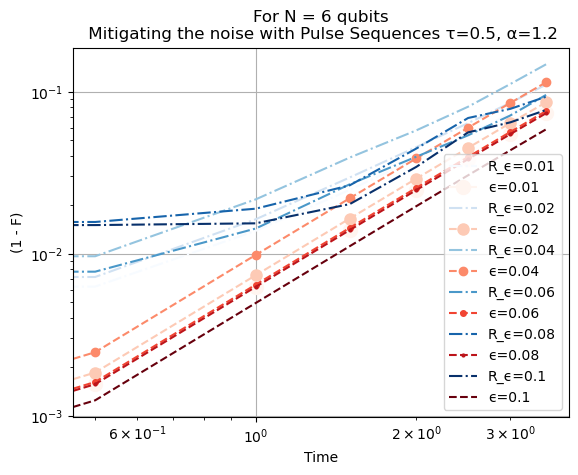

In [76]:
cls = 10
colors1 = plt.cm.Blues(np.linspace(0, 1, len(params['err_list'])))
colors2 = plt.cm.Reds(np.linspace(0, 1, len(params['err_list'])))
for i, err in enumerate(params['err_list']):
    params['err'] = err
    num_list = np.linspace(-2*params['err'], 2*params['err'], 2*params['N'])
    params['deltaError_list'] = np.random.choice(num_list, params['N'], replace=False)
    params['WF_Wx'] = WF_Generate(params, We = params['Wx'])
    params['pulses'] = PulseRotError(params, Wx = params['Wx'], Wy = params['Wy'])
    # print(params['pulses'])
    # print('\n')
    params['n'] = len(params['pulses'])
    params['opH'] = [X, Y] 
    n, N, r, op, pulses, psi_nm, R, alpha = initialVals(params)
    params['R'], params['r'] = R, r
    
    params['alpha'] = params['alpha_list'][0]

    psi_t, F, uOp, t = [], [], [], []
    params['tau'] = params['tau_list'][0]
    uOp_l, uOp_k, t = doubleAvg_RotAngle(params)

    # print(f'uOp_k = \n{uOp_k[1]}\n')
    psi_t = [normalizeWF(u@psi_nm) for i,u in enumerate(uOp_l)]
    F = [1-np.power(np.abs(np.vdot(psi_nm, pt)), 2) for pt in psi_t]
    # print(F[0])
    plt.plot(t, F, "-.", label = f"R_ϵ={params['err']}", ms=cls, color = colors1[i])
    
    psi_t = [normalizeWF(u@psi_nm) for i,u in enumerate(uOp_k)]
    F = [1-np.power(np.abs(np.vdot(psi_nm, pt)), 2) for pt in psi_t]
    # print(F[0])
    plt.plot(t, F, "--o", label = f"ϵ={params['err']}", ms=cls, color = colors2[i])
    
    cls -=2
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("(1 - F)")
    plt.title(f"For N = {params['N']} qubits\n Mitigating the noise with Pulse Sequences τ={params['tau']}, α={params['alpha']}")
    plt.grid('on')
plt.show()


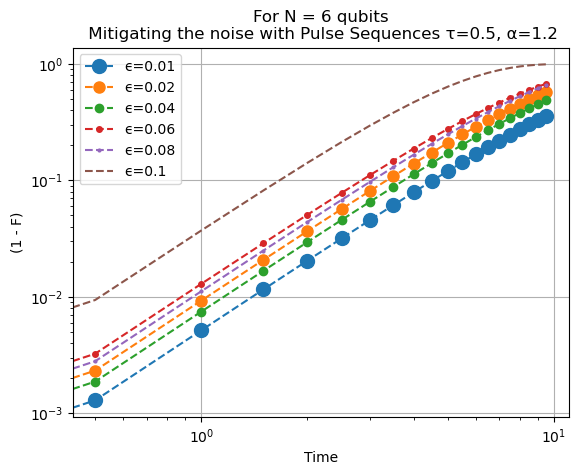

In [43]:
cls = 10
for err in params['err_list']:
    params['err'] = err
    num_list = np.linspace(-2*params['err'], 2*params['err'], 2*params['N'])
    params['deltaError_list'] = np.random.choice(num_list, params['N'], replace=False)
    params['WF_Wx'] = WF_Generate(params, We = params['Wx'])
    params['pulses'] = PulseRotError(params, Wx = params['Wx'], Wy = params['Wy'])
    params['n'] = len(params['pulses'])
    params['opH'] = [X, Y] 
    n, N, r, op, pulses, psi_nm, R, alpha = initialVals(params)
    params['R'], params['r'] = R, r
    
    params['alpha'] = params['alpha_list'][0]

    psi_t, F, uOp, t = [], [], [], []
    params['tau'] = params['tau_list'][0]
    uOp, t = WPSeq_TimeEvolOp(params)
    psi_t = [normalizeWF(u@psi_nm) for i,u in enumerate(uOp)]
    F = [1-np.power(np.abs(np.vdot(psi_nm, pt)), 2) for pt in psi_t]
    plt.plot(t, F, "--o", label = f"ϵ={params['err']}", ms=cls)
    cls -=2
    plt.yscale("log")
    plt.xscale("log")
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("(1 - F)")
    plt.title(f"For N = {params['N']} qubits\n Mitigating the noise with Pulse Sequences τ={params['tau']}, α={params['alpha']}")
    plt.grid('on')
plt.show()


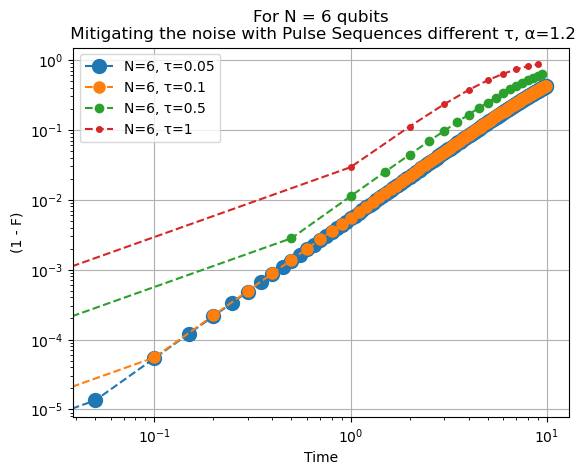

In [75]:
## With no rotational angle errors in Pulses
params['deltaError_list'] = [0 for _ in range(params['N'])]
# params['tau_list'] = [0.5, 1, 0.05, 0.1]
for alpha in params['alpha_list']:
    params['alpha'] = alpha

    cls = 10
    for tau in [0.05, 0.1, 0.5, 1]:
        psi_t, F, uOp, t = [], [], [], []
        params['tau'] = tau
        uOp, t = WPSeq_TimeEvolOp(params)
        psi_t = [normalizeWF(u@psi_nm) for i,u in enumerate(uOp)]
        F = [1-np.power(np.abs(np.vdot(psi_nm, pt)), 2) for pt in psi_t]
        plt.plot(t, F, "--o", label = f"N={params['N']}, τ={tau}", ms=cls)
        cls -=2
        plt.yscale("log")
        plt.xscale("log")
        plt.legend()
        plt.xlabel("Time")
        plt.ylabel("(1 - F)")
        plt.title(f"For N = {params['N']} qubits\n Mitigating the noise with Pulse Sequences different τ, α={params['alpha']}")
        plt.grid('on')
    plt.show()


In [26]:
# When the delta values for each qubits are close to each other,
# fidelity for all taus show the same patter.
# When they are further apart from each other (step difference less than
# order of -2), fidelity shows stark difference for different taus but 
# overlap for higher values of alpha.

In [80]:
theta = np.pi/6
Ry = np.array([[np.cos(theta/2), np.sin(theta/2)], [-np.sin(theta/2), np.cos(theta/2)]])
print(np.linalg.inv(Ry)@X@Ry)

[[-0.5        0.8660254]
 [ 0.8660254  0.5      ]]


In [81]:
print(np.array([[-np.sin(theta), np.cos(theta)], [np.cos(theta), np.sin(theta)]]))

[[-0.5        0.8660254]
 [ 0.8660254  0.5      ]]


In [140]:
original_list = [[1, -1, 1, -1], [1, 1, -1, -1]]
transposed_list = [list(row) for row in zip(*original_list)]
print(transposed_list)

[[1, 1], [-1, 1], [1, -1], [-1, -1]]


In [79]:
lst = np.arange(0, 4*0.5, 0.5)
print(lst)

[0.  0.5 1.  1.5]
